In [19]:
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import os
import re

# Leer datos Indices de Rezago Social

In [20]:
folders_IRS = os.listdir("data/")
folders_IRS = ["data/"+i for i in folders_IRS if "IRS" in i]
folders_IRS

['data/IRS_localidades_2000.xlsx',
 'data/IRS_localidades_2005.xlsx',
 'data/IRS_localidades_2010.xlsx',
 'data/IRS_localidades_2020.xlsx']

In [21]:
rename_columns = {
    "Indicadores de rezago social (porcentaje)":np.NaN,
    "Entidad \nfederativa":"Entidad federativa",
    "Población \ntotal":"Población total",
}

In [22]:
def loadISR(folders_IRS):
    ISR_full = pd.DataFrame()
    colnames = []

    for folder in folders_IRS:
        ISR_df = pd.ExcelFile(folder)
        year = folder[:-5].split("_")[-1]
        for sheet in ISR_df.sheet_names:
            ISR_sheet = ISR_df.parse(sheet, skiprows=4)
            ISR_sheet.replace(rename_columns, inplace=True)
            ISR_sheet[:2] = ISR_sheet[:2].fillna(method="bfill")

            ISR_sheet.columns = ISR_sheet.iloc[0]
            ISR_sheet.drop(ISR_sheet.index[0], inplace=True)
            ISR_sheet.dropna(subset="Localidad", inplace=True)
            ISR_sheet.dropna(how="all", axis=1, inplace=True)
            ISR_sheet["year"] = year

            ISR_full = pd.concat([ISR_full, ISR_sheet], ignore_index=True)
            colnames.append(ISR_sheet.columns)

    return ISR_full
#ISR_full = loadISR(folders_IRS)
#ISR_full.to_csv("data/ISR_full.csv",index=False)
ISR_full = pd.read_csv("data/ISR_full.csv")
ISR_full["Entidad federativa"] = [i.lower().title() for i in ISR_full["Entidad federativa"]]

ISR_full["Entidad federativa"].replace({
    "Varacruz De Ignacio De La Llave":"Veracruz De Ignacio De La Llave",
    "Distrito Federal":"Ciudad De México",
    "Querétaro":"Querétaro De Arteaga"}, inplace=True)
ISR_full

,Clave localidad,Entidad federativa,Municipio,Localidad,Población total,Población de 15 años o más analfabeta,Población de 6 a 14 años que no asiste a la escuela,Población de 15 años y más con educación básica incompleta,Población sin derechohabiencia a servicios de salud,Viviendas con piso de tierra,...,Viviendas que no disponen de drenaje,Viviendas que no disponen de energía eléctrica,Viviendas que no disponen de lavadora,Viviendas que no disponen de refrigerador,Índice de rezago social,Grado de rezago social,Lugar que ocupa en el contexto nacional,year,"Hogares con población de 15 a 29 años, con algún habitante con menos de 9 años de educación aprobados",Promedio de ocupantes por cuarto
0,10010001,Aguascalientes,AGUASCALIENTES,AGUASCALIENTES,594092,3.407850,5.145010,40.869800,34.093040,1.909650,...,0.979540,0.762040,17.940530,10.573430,-2.447551,Muy bajo,106455.0,2000,NaN,NaN
1,10010096,Aguascalientes,AGUASCALIENTES,AGUA AZUL,79,20.833330,5.882350,85.416670,53.164560,6.666670,...,73.333330,13.333330,53.333340,33.333330,-0.599735,Bajo,77208.0,2000,NaN,NaN
2,10010106,Aguascalientes,AGUASCALIENTES,ARELLANO,1059,8.681130,11.153850,69.282140,47.780930,7.462690,...,5.472640,2.985070,41.293530,27.363180,-1.752400,Muy bajo,102049.0,2000,NaN,NaN
3,10010112,Aguascalientes,AGUASCALIENTES,BAJIO LOS VAZQUEZ,69,12.000000,0.000000,82.000000,89.855070,0.000000,...,50.000000,0.000000,33.333330,25.000000,-1.364606,Bajo,95650.0,2000,NaN,NaN
4,10010120,Aguascalientes,AGUASCALIENTES,BUENAVISTA DE PEÑUELAS,588,16.164380,6.569340,72.602740,27.551020,0.862070,...,13.793100,0.000000,35.344830,16.379310,-1.861600,Muy bajo,103293.0,2000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423462,320580030,Zacatecas,Santa María de la Paz,Las Tablas,34,12.000000,0.000000,56.000000,0.000000,7.692308,...,38.461538,0.000000,30.769231,23.076923,-0.375147,Bajo,59280.0,2020,NaN,NaN
423463,320580033,Zacatecas,Santa María de la Paz,Los Horcones,12,16.666667,0.000000,100.000000,16.666667,28.571429,...,57.142857,0.000000,28.571429,28.571429,0.192058,Medio,34484.0,2020,NaN,NaN
423464,320580035,Zacatecas,Santa María de la Paz,Los Trigos (Mesa de los Trigos),89,4.411765,0.000000,55.882353,15.730337,4.347826,...,13.043478,4.347826,21.739130,8.695652,-0.628247,Bajo,75373.0,2020,NaN,NaN
423465,320580037,Zacatecas,Santa María de la Paz,Mesa Grande,165,2.400000,3.571429,60.000000,10.303030,8.163265,...,20.408163,0.000000,12.244898,0.000000,-0.806189,Bajo,87671.0,2020,NaN,NaN


In [23]:
ISR_full.columns

Index(['Clave localidad', 'Entidad federativa', 'Municipio', 'Localidad',
       'Población total', 'Población de 15 años o más analfabeta',
       'Población de 6 a 14 años que no asiste a la escuela',
       'Población de 15 años y más con educación básica incompleta',
       'Población sin derechohabiencia a servicios de salud',
       'Viviendas con piso de tierra',
       'Viviendas que no disponen de excusado o sanitario',
       'Viviendas que no disponen de agua entubada de la red pública',
       'Viviendas que no disponen de drenaje',
       'Viviendas que no disponen de energía eléctrica',
       'Viviendas que no disponen de lavadora',
       'Viviendas que no disponen de refrigerador', 'Índice de rezago social',
       'Grado de rezago social', 'Lugar que ocupa en el contexto nacional',
       'year',
       'Hogares con población de 15 a 29 años, con algún habitante con menos de 9 años de educación aprobados',
       'Promedio de ocupantes por cuarto'],
      dtype='objec

# Datos DAYMET

In [24]:
#daymet_root = "data/daymet/"
#list_daymet = os.listdir(daymet_root)
#list_daymet = [daymet_root+i for i in list_daymet]
#print(len(list_daymet))
#list_daymet[:5]

In [25]:
code_ent = {
    1: "AGUASCALIENTES",
    2: "BAJA CALIFORNIA",
    3: "BAJA CALIFORNIA SUR",
    4: "CAMPECHE",
    5: "COAHUILA DE ZARAGOZA",
    6: "COLIMA",
    7: "CHIAPAS",
    8: "CHIHUAHUA",
    9: "DISTRITO FEDERAL",
    10: "DURANGO",
    11: "GUANAJUATO",
    12: "GUERRERO",
    13: "HIDALGO",
    14: "JALISCO",
    15: "MEXICO",
    16: "MICHOACAN DE OCAMPO",
    17: "MORELOS",
    18: "NAYARIT",
    19: "NUEVO LEON",
    20: "OAXACA",
    21: "PUEBLA",
    22: "QUERETARO DE ARTEAGA",
    23: "QUINTANA ROO",
    24: "SAN LUIS POTOSI",
    25: "SINALOA",
    26: "SONORA",
    27: "TABASCO",
    28: "TAMAULIPAS",
    29: "TLAXCALA",
    30: "VERACRUZ DE IGNACIO DE LA LLAVE",
    31: "YUCATAN",
    32: "ZACATECAS"}

In [26]:
def read_daymet(dirs):
    df_final = pd.DataFrame(columns=[
        "dayl","prcp","srad","swe","tmax","tmin","vp", 'CVE_ENT', 'date'
    ])
    for dir in dirs:
        df = pd.read_csv(dir)
        date = dir[12:-4]
        df["date"] = date

        df.drop(columns=["NOMGEO","CVE_MUN","CVE_LOC","AMBITO","CVEGEO","system:index"],
                inplace=True)

        df_final["CVE_ENT"].replace(code_ent, inplace=True)
        print(df_final.columns, date)
        df_final = pd.concat([df_final, df])
        df_final.to_csv(f"data/daymet_parcial.csv",index=False)

    df_final["date"] = pd.to_datetime(df_final["date"],
                                      infer_datetime_format=True)
    df_final["week_index"] = df_final.date.dt.week
    df_final["year"] = df_final.date.dt.year

    df_final.rename(columns={"CVE_ENT":"estado"}, inplace=True)

    return df_final

#df_daymet = read_daymet(list_daymet)
#df_daymet.to_csv("data/daymet_full.csv",index=False)
df_daymet = pd.read_csv("data/daymet_full.csv")
#df_daymet.drop(columns="date",inplace=True)
df_daymet.head()

,estado,year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT,date
0,Aguascalientes,2000,1,38569.752366,0.0,421.139878,0.0,22.647606,1.195663,302.881345,1.0,2000-01-06 00:00:00
1,Aguascalientes,2000,2,38785.064030,0.0,412.376690,0.0,22.635875,2.480746,328.648852,1.0,2000-01-13 00:00:00
2,Aguascalientes,2000,3,39067.301995,0.0,441.500852,0.0,22.363806,0.680293,249.668226,1.0,2000-01-20 00:00:00
3,Aguascalientes,2000,4,39409.100832,0.0,456.997165,0.0,23.790566,1.858065,247.247024,1.0,2000-01-27 00:00:00
4,Aguascalientes,2000,5,39802.388079,0.0,462.369302,0.0,22.275614,1.152001,234.512377,1.0,2000-02-03 00:00:00


In [27]:
df_daymet["estado"].replace(code_ent, inplace=True)
df_daymet["estado"] = [i.lower().title() for i in df_daymet["estado"] ]
df_daymet.estado.unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Ciudad De México',
       'Coahuila De Zaragoza', 'Colima', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Michoacán De Ocampo', 'Morelos',
       'México', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro',
       'Quintana Roo', 'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco',
       'Tamaulipas', 'Tlaxcala', 'Veracruz De Ignacio De La Llave',
       'Yucatán', 'Zacatecas'], dtype=object)

# Leer datos dengue

In [28]:
dengue_sheets = pd.ExcelFile("data/dengue-climate.xlsx")

In [29]:
def groupdenguedata(sheets, excelfile):
    dfDengue = pd.DataFrame()

    for sheet in sheets:

        dfi = excelfile.parse(sheet, skiprows=2)
        dfi = dfi[dfi["id"] < 33]
        dfi.drop(columns=["id"], inplace=True)

        dfiMelted = dfi.melt(id_vars=["estado","year"], var_name="semana", value_name="casos")
        dfiMelted["year"] = dfiMelted["year"].astype(int)

        dfiMelted["clase"] = [re.split(pattern="_\d", string=i)[0] for i in dfiMelted["semana"]]
        dfiMelted["week"]  = [re.split(pattern="_", string=i)[-1] for i in dfiMelted["semana"]]

        dfiMelted = dfiMelted[dfiMelted[""]]
        
        dict_clases = {
            "clas":"Clásico",
            "h_e":"Hemorrágico",
            "h_c":"Hemorrágico (confirmado)",
            " ":0,
            "-":0,
            "-----":0
        }
        
        dfiMelted.replace(dict_clases, inplace=True)

        dfiMelted["date"] = dfiMelted["year"].astype(str) + "-" +dfiMelted["week"]+"-1"
        dfiMelted["date"] = pd.to_datetime(dfiMelted["date"], format="%Y-%W-%w")


        dfDengue = pd.concat([dfDengue, dfiMelted])
    dfDengue["casos"].replace({
        "-":np.NaN,
        "n.e.":np.NaN,
        "n.e. ":np.NaN,
        "n.d ":np.NaN,
        "-----":np.NaN,
        " ":np.NaN,
        'n.e':np.NaN
        }, inplace=True)

    dfDengue["casos"].fillna(0, inplace=True)
    dfDengue["casos"] = dfDengue["casos"].astype(int)
    return dfDengue

In [30]:
#dfDengue = groupdenguedata(dengue_sheets.sheet_names, dengue_sheets)
#dfDengue.to_csv("dengue_full.csv", index=False)

dfDengue = pd.read_csv("data/dengue_full.csv")
dfDengue = dfDengue[dfDengue["clase"] != 'Dengue hemorrágico (en estudio)']
dfDengue.replace({"Dengue hemorrágico (confirmado)":"Hemorrágico",
                         "Dengue clásico":"Clásico"}, inplace=True)
dfDengue.head()

,estado,year,semana,casos,clase,week,date
0,Aguascalientes,2002,clas_1,0,Clásico,1,2002-01-07
1,Baja California,2002,clas_1,0,Clásico,1,2002-01-07
2,Baja California Sur,2002,clas_1,0,Clásico,1,2002-01-07
3,Campeche,2002,clas_1,3,Clásico,1,2002-01-07
4,Coahuila,2002,clas_1,0,Clásico,1,2002-01-07


In [31]:
dfDengue.clase.unique()

array(['Clásico', 'Hemorrágico'], dtype=object)

In [32]:
dfDengue = dfDengue.pivot_table(values="casos", columns="clase", index=["estado","date"])
dfDengue.head(3)

clase                      Clásico  Hemorrágico
estado         date                            
Aguascalientes 2002-01-07        0            0
               2002-01-14        0            0
               2002-01-21        0            0

In [33]:
dfDengue.reset_index(inplace=True, drop=False)
dfDengue["date"] = pd.to_datetime(dfDengue["date"])
dfDengue["date"] = pd.DatetimeIndex(dfDengue.date) - pd.DateOffset(1)
dfDengue["year"] = dfDengue.date.dt.year
dfDengue["week_index"] =  dfDengue.date.dt.isocalendar().week
dfDengue.head()

clase,estado,date,Clásico,Hemorrágico,year,week_index
0,Aguascalientes,2002-01-06,0,0,2002,1
1,Aguascalientes,2002-01-13,0,0,2002,2
2,Aguascalientes,2002-01-20,0,0,2002,3
3,Aguascalientes,2002-01-27,0,0,2002,4
4,Aguascalientes,2002-02-03,0,0,2002,5


# Unir Daymet y Dengue

In [34]:
df_daymet.head()

,estado,year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT,date
0,Aguascalientes,2000,1,38569.752366,0.0,421.139878,0.0,22.647606,1.195663,302.881345,1.0,2000-01-06 00:00:00
1,Aguascalientes,2000,2,38785.064030,0.0,412.376690,0.0,22.635875,2.480746,328.648852,1.0,2000-01-13 00:00:00
2,Aguascalientes,2000,3,39067.301995,0.0,441.500852,0.0,22.363806,0.680293,249.668226,1.0,2000-01-20 00:00:00
3,Aguascalientes,2000,4,39409.100832,0.0,456.997165,0.0,23.790566,1.858065,247.247024,1.0,2000-01-27 00:00:00
4,Aguascalientes,2000,5,39802.388079,0.0,462.369302,0.0,22.275614,1.152001,234.512377,1.0,2000-02-03 00:00:00


In [58]:
df_dengue_daymet = dfDengue.merge(df_daymet, on=["estado","year","week_index"], how="inner")
df_dengue_daymet.rename(columns={"estado":"Entidad federativa"}, inplace=True)
df_dengue_daymet

,Entidad federativa,date_x,Clásico,Hemorrágico,year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT,date_y
0,Aguascalientes,2002-01-06,0,0,2002,1,38490.104891,0.000000,412.658447,0.0,21.732162,1.271458,447.737208,1.0,2002-04-03 18:00:00
1,Aguascalientes,2002-01-13,0,0,2002,2,38684.202857,4.695578,379.339061,0.0,20.654242,1.531907,443.580977,1.0,2002-01-10 00:00:00
2,Aguascalientes,2002-01-20,0,0,2002,3,38938.597047,0.000000,424.981418,0.0,22.494717,2.036284,503.612944,1.0,2002-01-17 00:00:00
3,Aguascalientes,2002-01-27,0,0,2002,4,39255.830578,0.000000,429.856307,0.0,23.342400,3.478972,480.582798,1.0,2002-01-24 00:00:00
4,Aguascalientes,2002-02-03,0,0,2002,5,39628.063254,0.000000,447.646493,0.0,24.657705,4.532387,415.675041,1.0,2002-01-31 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26671,Zacatecas,2020-11-29,0,0,2020,48,38516.551772,0.000000,378.852307,0.0,25.104916,7.252191,775.787390,32.0,2020-11-26 00:00:00
26672,Zacatecas,2020-12-06,0,0,2020,49,38281.518666,0.336430,383.272928,0.0,21.006084,2.734376,509.366442,32.0,2020-12-03 00:00:00
26673,Zacatecas,2020-12-13,0,0,2020,50,38123.916678,0.000000,379.154386,0.0,22.240216,5.068265,381.561733,32.0,2020-12-10 00:00:00
26674,Zacatecas,2020-12-20,0,0,2020,51,38048.463078,0.000000,410.478614,0.0,23.080537,3.146933,273.529405,32.0,2020-12-17 00:00:00


# Selección de estados con peor Indice de Rezago Social

In [59]:
metricas_IRS = {
    'Población total':"sum",
    'Población de 15 años o más analfabeta':"mean",
    'Población de 6 a 14 años que no asiste a la escuela':"mean",
    'Población de 15 años y más con educación básica incompleta':"mean",
    'Población sin derechohabiencia a servicios de salud':"mean",
    'Viviendas con piso de tierra':"mean",
    'Viviendas que no disponen de excusado o sanitario':"mean",
    'Viviendas que no disponen de agua entubada de la red pública':"mean",
    'Viviendas que no disponen de drenaje':"mean",
    'Viviendas que no disponen de energía eléctrica':"mean",
    'Viviendas que no disponen de lavadora':"mean",
    'Viviendas que no disponen de refrigerador':"mean",
    'Índice de rezago social':"mean",
    #'Grado de rezago social':"mean"
}
ISR_grouped = ISR_full.groupby(by=["Entidad federativa","year"],as_index=False).agg(metricas_IRS)
ISR_grouped

,Entidad federativa,year,Población total,Población de 15 años o más analfabeta,Población de 6 a 14 años que no asiste a la escuela,Población de 15 años y más con educación básica incompleta,Población sin derechohabiencia a servicios de salud,Viviendas con piso de tierra,Viviendas que no disponen de excusado o sanitario,Viviendas que no disponen de agua entubada de la red pública,Viviendas que no disponen de drenaje,Viviendas que no disponen de energía eléctrica,Viviendas que no disponen de lavadora,Viviendas que no disponen de refrigerador,Índice de rezago social
0,Aguascalientes,2000,936574,10.930003,11.195445,74.547689,62.373480,10.032481,35.605941,22.531630,40.995041,16.000521,50.150136,44.864418,-1.104847
1,Aguascalientes,2005,1058146,9.572598,6.815779,64.141214,29.914383,5.245232,21.341822,31.541837,24.173722,9.628286,35.275086,24.045499,-1.065121
2,Aguascalientes,2010,1177901,7.429436,4.884449,55.989686,22.018093,3.879390,13.630822,21.854259,16.540648,6.038195,31.257639,19.234665,-0.957932
3,Aguascalientes,2020,1418881,4.939935,5.311406,39.872213,22.493482,2.536156,5.051712,7.186626,7.212335,3.239929,20.631158,11.639619,-0.818566
4,Baja California,2000,2474721,8.562765,11.167313,65.057129,43.952923,12.583078,10.346601,47.863118,53.682698,19.754405,43.906391,27.814091,-1.359880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Yucatán,2020,2315986,14.814792,5.018972,52.293401,18.091627,6.478154,22.497516,8.829993,25.613254,5.943169,47.145368,44.168513,-0.031026
124,Zacatecas,2000,1341477,12.926655,14.759248,84.391775,82.508268,18.830317,54.190491,49.639324,68.949119,19.465342,64.721109,52.872200,-0.450014
125,Zacatecas,2005,1356266,12.199800,9.804334,75.725834,74.626073,13.867611,36.083105,37.740486,40.520474,9.647877,47.342455,31.906858,-0.631761
126,Zacatecas,2010,1480822,9.777026,5.425653,66.357085,39.943610,7.777724,26.734361,33.414915,31.728471,7.171762,39.467370,25.098396,-0.553185


In [60]:
ISR_grouped = ISR_full.groupby(by=["Entidad federativa"]).agg(
    {"Índice de rezago social":"mean",
     "Población total":"sum"})

ISR_grouped.sort_values("Índice de rezago social", ascending=False, inplace=True)
lista_ISR = ISR_grouped.iloc[:3]
lista_ISR = pd.concat([lista_ISR,ISR_grouped.iloc[-3:]])
lista_ISR

,Índice de rezago social,Población total
Entidad federativa,,
Guerrero,0.730710,13069745
Chihuahua,0.581498,13290525
Chiapas,0.508659,18209587
Colima,-0.761249,2475822
Baja California,-0.932690,12198170
Aguascalientes,-0.978851,4591502


# Extraer estados con más casos

In [62]:
df_dengue_daymet.groupby("Entidad federativa").agg({
    "Clásico":"sum",
    "Hemorrágico":"sum",
})

,Clásico,Hemorrágico
Entidad federativa,,
Aguascalientes,50,2
Baja California,295,1
Baja California Sur,11758,725
Campeche,8286,1038
Chiapas,19306,9893
Chihuahua,67,129
Colima,42393,3300
Durango,2427,25
Guanajuato,5222,20


### Primer graph

In [63]:
df1_graph1 = df_dengue_daymet.groupby(["Entidad federativa"], as_index=False).agg({
    "Clásico":"sum",
    "Hemorrágico":"sum"
})
df1_graph1.head()

,Entidad federativa,Clásico,Hemorrágico
0,Aguascalientes,50,2
1,Baja California,295,1
2,Baja California Sur,11758,725
3,Campeche,8286,1038
4,Chiapas,19306,9893


In [64]:
ISR_grouped.head()

,Índice de rezago social,Población total
Entidad federativa,,
Guerrero,0.730710,13069745
Chihuahua,0.581498,13290525
Chiapas,0.508659,18209587
Oaxaca,0.388832,14823794
Nayarit,0.263368,4151434


In [69]:

df2_graph1 = ISR_grouped.groupby(["Entidad federativa"], as_index=True).agg({
  "Población total":"mean",
})
df2_graph1.head()


,Población total
Entidad federativa,
Aguascalientes,4591502.0
Baja California,12198170.0
Baja California Sur,2334613.0
Campeche,3157455.0
Chiapas,18209587.0


In [70]:
graph1 = pd.merge(df1_graph1, df2_graph1, on="Entidad federativa")
graph1["Clásico"] = graph1["Clásico"]/graph1["Población total"]*100000
graph1["Hemorrágico"] = graph1["Hemorrágico"]/graph1["Población total"]*100000
graph1.head()

,Entidad federativa,Clásico,Hemorrágico,Población total
0,Aguascalientes,1.088968,0.043559,4591502.0
1,Baja California,2.418396,0.008198,12198170.0
2,Baja California Sur,503.638076,31.054397,2334613.0
3,Campeche,262.426543,32.874578,3157455.0
4,Chiapas,106.021076,54.328525,18209587.0


In [71]:
# Long to wide
graph1 = graph1.melt(
  id_vars="Entidad federativa", 
  value_vars=["Clásico","Hemorrágico"], 
  var_name="Tipo de dengue", 
  value_name="Casos por 100,000 habitantes")

#graph1.sort_values(["Tipo de dengue","Casos por 100,000 habitantes"], ascending=(),inplace=True)
graph1.sort_values(["Tipo de dengue","Casos por 100,000 habitantes"], ascending=[True, False],inplace=True)
graph1.head()

,Entidad federativa,Tipo de dengue,"Casos por 100,000 habitantes"
6,Colima,Clásico,1712.279800
2,Baja California Sur,Clásico,503.638076
12,Morelos,Clásico,293.843857
17,Quintana Roo,Clásico,282.286958
24,Yucatán,Clásico,278.527882


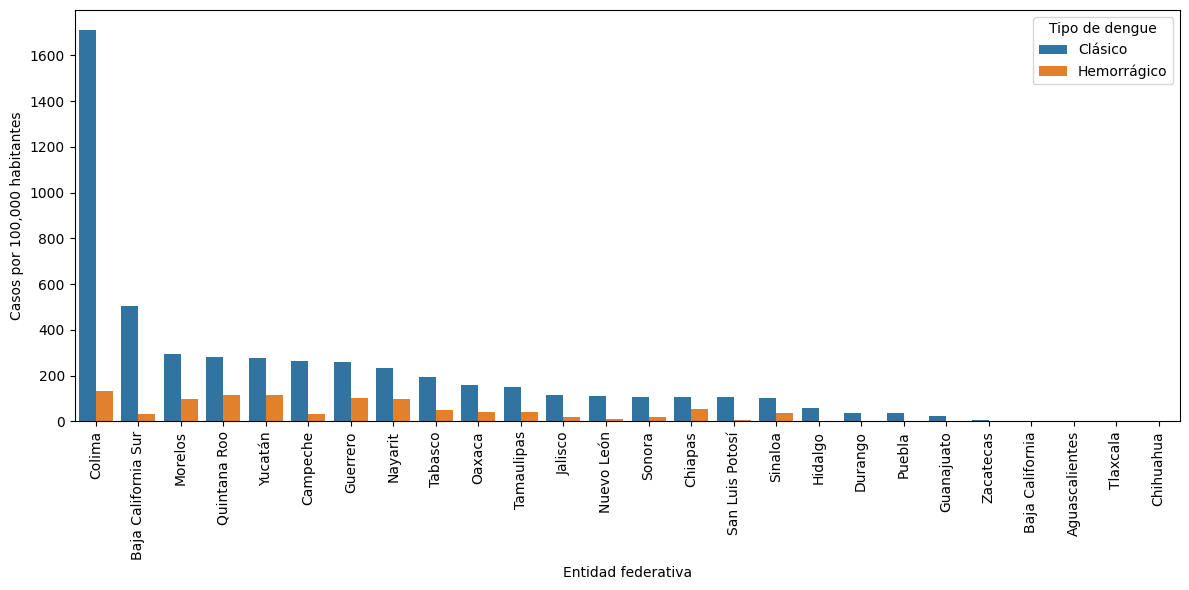

In [72]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(
  x="Entidad federativa", 
  y="Casos por 100,000 habitantes", 
  hue="Tipo de dengue", 
  data=graph1,
  ax=ax)

# log scale
#ax.set_yscale("log")

# rotate xticks 90 degrees
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Segundo grafico

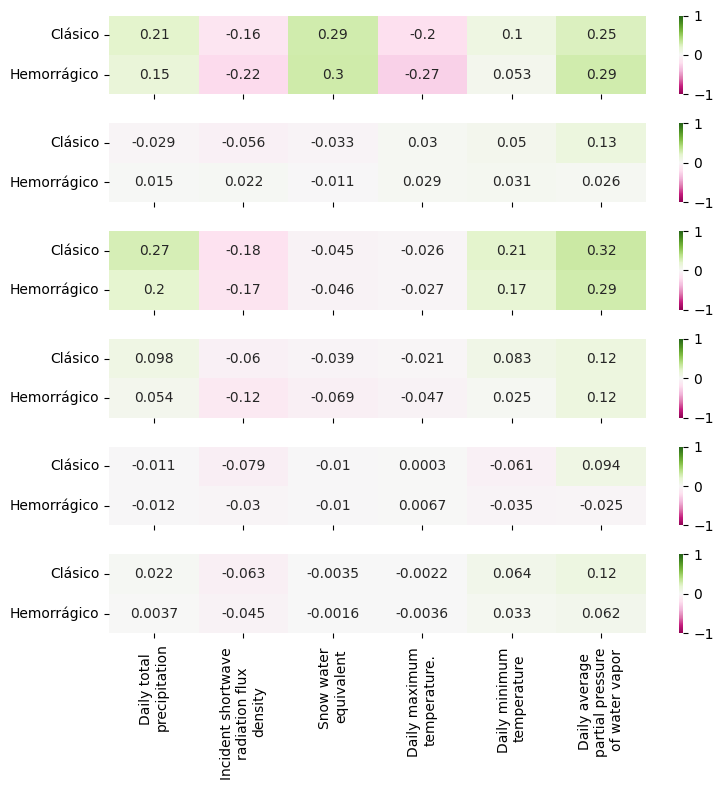

In [76]:
# Usar 5 estados con peor ISR
dfISR_worst = df_dengue_daymet[df_dengue_daymet["Entidad federativa"].isin(lista_ISR.index)]
dfISR_worst
dict_daymetcols = {
    "dayl":"Duration of the \ndaylight period",
    "prcp":"Daily total \nprecipitation",
    "srad":"Incident shortwave \nradiation flux \ndensity",
    "swe":"Snow water \nequivalent",
    "tmax":"Daily maximum \ntemperature.",
    "tmin":"Daily minimum \ntemperature",
    "vp":"Daily average \npartial pressure \nof water vapor",
}
selected = ['Clásico', 'Hemorrágico',
      'dayl', 'prcp',
       'srad', 'swe', 'tmax', 'tmin', 'vp']


nrows = 6
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8), sharey=True, sharex=True)

i = 0
for r in range(nrows):
    
    state = lista_ISR.index[i]
    ISR_value = lista_ISR.values[i]
    df_i = dfISR_worst[dfISR_worst["Entidad federativa"]==state].copy()
    df_i = df_i[selected].corr().iloc[:2,3:]
    
    df_i.rename(columns=dict_daymetcols, inplace=True)
    sns.heatmap(df_i, ax=ax[r],annot=True, center=0, vmax=1, vmin=-1, cmap="PiYG")
    i += 1

plt.tight_layout()
#plt.savefig("heatmapcorr.png", dpi=300)
plt.show()


## Tercer grafico

In [78]:
print(df_dengue_daymet.shape)
df_dengue_daymet.head()

(26676, 15)


,Entidad federativa,date_x,Clásico,Hemorrágico,year,week_index,dayl,prcp,srad,swe,tmax,tmin,vp,CVE_ENT,date_y
0,Aguascalientes,2002-01-06,0,0,2002,1,38490.104891,0.000000,412.658447,0.0,21.732162,1.271458,447.737208,1.0,2002-04-03 18:00:00
1,Aguascalientes,2002-01-13,0,0,2002,2,38684.202857,4.695578,379.339061,0.0,20.654242,1.531907,443.580977,1.0,2002-01-10 00:00:00
2,Aguascalientes,2002-01-20,0,0,2002,3,38938.597047,0.000000,424.981418,0.0,22.494717,2.036284,503.612944,1.0,2002-01-17 00:00:00
3,Aguascalientes,2002-01-27,0,0,2002,4,39255.830578,0.000000,429.856307,0.0,23.342400,3.478972,480.582798,1.0,2002-01-24 00:00:00
4,Aguascalientes,2002-02-03,0,0,2002,5,39628.063254,0.000000,447.646493,0.0,24.657705,4.532387,415.675041,1.0,2002-01-31 00:00:00


In [ ]:
## iterate over 

## Cuarto grafico mapa

In [ ]:
import pandas as pd
import plotly.express as px

# Leer los datos
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv", dtype={"fips": str})

# Crear el mapa bivariado
fig = px.choropleth(df, geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json", locations="fips", color="unemp",
                    color_continuous_scale="Viridis",
                    range_color=(0, 12),
                    scope="usa",
                    hover_data=["state", "pop"],
                    labels={"unemp":"Desempleo", "pop":"Población"}
                   )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

ValueError: Value of 'hover_data_0' is not the name of a column in 'data_frame'. Expected one of ['fips', 'unemp'] but received: state